In [1]:
# Authenticate to use Google Cloud services
from google.colab import auth
auth.authenticate_user()

In [2]:
# Import BigQuery (client)
from google.cloud import bigquery
import pandas as pd

In [3]:
# Set up BQ client, i.e., an interface for colab to access BQ
# via SQL queries
project_id = 'XXX' # you can find your own project id at your google cloud console: console.cloud.google.com
client = bigquery.Client(project=project_id)

In [4]:
# Preview the dataset to be explored: GA4 e-commerce dataset

# Question: how many tables are there in the dataset?
dataset_id = 'ga4_obfuscated_sample_ecommerce'
dataset_ref = bigquery.DatasetReference("bigquery-public-data", dataset_id)
dataset = client.get_dataset(dataset_ref)
tables = list(client.list_tables(dataset))
print(f"Total tables in '{dataset_id}': {len(tables)}")
print("First 5 table IDs:")
for table in tables[:5]:
  print("-", table.table_id)
#for table in tables:
#  print(table.table_id)

Total tables in 'ga4_obfuscated_sample_ecommerce': 92
First 5 table IDs:
- events_20201101
- events_20201102
- events_20201103
- events_20201104
- events_20201105


In [5]:
# Query 1: find out what are in one sample table
query = """
SELECT *
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20201102`
LIMIT 5
"""
df = client.query(query).to_dataframe()
df.head()

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,...,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items
0,20201102,1604340888557778,page_view,"[{'key': 'ga_session_id', 'value': {'string_va...",<NA>,NaN,9918873824,<NA>,None,1001568.5746990412,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': '<...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
1,20201102,1604341115204117,user_engagement,"[{'key': 'engagement_time_msec', 'value': {'st...",<NA>,NaN,-459154996,<NA>,None,1001568.5746990412,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': '<...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
2,20201102,1604341121120868,page_view,"[{'key': 'session_engaged', 'value': {'string_...",<NA>,NaN,4602170393,<NA>,None,1001568.5746990412,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': '<...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
3,20201102,1604340888557778,first_visit,"[{'key': 'ga_session_id', 'value': {'string_va...",<NA>,NaN,9918873824,<NA>,None,1001568.5746990412,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': '<...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
4,20201102,1604340888557778,session_start,"[{'key': 'page_location', 'value': {'string_va...",<NA>,NaN,9918873824,<NA>,None,1001568.5746990412,...,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': '<...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]


## Question 1: Where do users drop off in the funnel?
Rationale: This helps identify friction in the user journey and optimize funnel stages. This is critical for growth, conversion optimization, and marketing spend efficiency.

Data: For this part we use the most recent data (i.e., events from 20210124 to 20210129) to ensure that our investigation and marketing/maintenance strategies to be made accordingly will be up-to-date.

Events: _view-item_, _add-to-cart_, _begin-checkout_, _purchase_ (that is, those relevant to the purchasing process)

In [6]:
# SQL query
# It Picks data from 20210124 to 20210129
# And Turns each event (view, add, checkout, purchase) into a 1/0 column per user,
# Then Groups by user_pseudo_id so each row = one unique user
query = """
SELECT
  user_pseudo_id,
  MAX(IF(event_name = 'view_item', 1, 0)) AS Viewed,
  MAX(IF(event_name = 'add_to_cart', 1, 0)) AS AddedToCart,
  MAX(IF(event_name = 'begin_checkout', 1, 0)) AS CheckoutStarted,
  MAX(IF(event_name = 'purchase', 1, 0)) AS Purchased
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20210124' AND '20210129'
  AND event_name IN ('view_item', 'add_to_cart', 'begin_checkout', 'purchase')
GROUP BY
  user_pseudo_id
"""

# Fetch data
df_funnel = client.query(query).to_dataframe()
df_funnel.head()

,user_pseudo_id,Viewed,AddedToCart,CheckoutStarted,Purchased
0,1008400.2068823524,1,0,0,0
1,1045984.0135048258,1,0,0,0
2,1049616.0363781774,1,0,0,0
3,1067975.1082866411,1,0,0,0
4,1100005.5150713296,1,0,0,0


In [7]:
# Now double check if data makes sense, meaning that people who
# viewed the product should be more than those who purchased
df_funnel.describe()

,Viewed,AddedToCart,CheckoutStarted,Purchased
count,5125.0,5125.0,5125.0,5125.0
mean,0.997659,0.176,0.098537,0.057951
std,0.048337,0.380857,0.298068,0.233674
min,0.0,0.0,0.0,0.0
25%,1.0,0.0,0.0,0.0
50%,1.0,0.0,0.0,0.0
75%,1.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0


/tmp/ipython-input-8-3260740965.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=stages, palette="Blues_d")


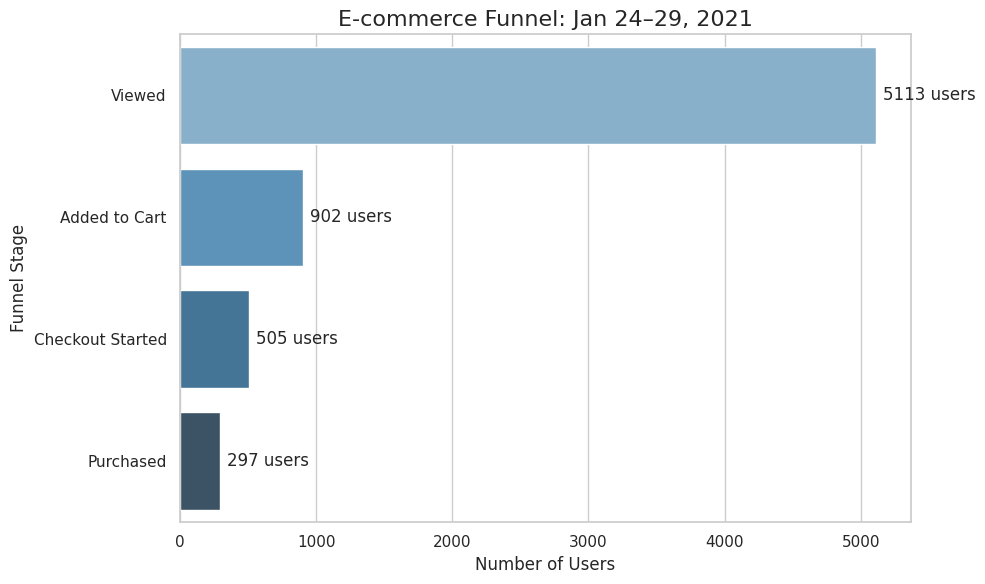

In [8]:
# Visualise the turnout rate per event

import matplotlib.pyplot as plt
import seaborn as sns

# User counts per funnel stage
funnel_counts = {
  "Viewed": df_funnel["Viewed"].sum(),
  "Added to Cart": df_funnel["AddedToCart"].sum(),
  "Checkout Started": df_funnel["CheckoutStarted"].sum(),
  "Purchased": df_funnel["Purchased"].sum()
}

# Prepare for plotting
stages = list(funnel_counts.keys())
counts = list(funnel_counts.values())

# Style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=stages, palette="Blues_d")

# Add text labels
for i, count in enumerate(counts):
    plt.text(count + 50, i, f"{int(count)} users", va='center', fontsize=12)

plt.title("E-commerce Funnel: Jan 24–29, 2021", fontsize=16)
plt.xlabel("Number of Users")
plt.ylabel("Funnel Stage")
plt.tight_layout()

# Save figure
plt.savefig('user_funnel.png', dpi=300)

plt.show()

In [9]:
# Compute Conversion rates between stages
conversion_rates = {
    "View → Add to Cart": funnel_counts["Added to Cart"] / funnel_counts["Viewed"],
    "Add to Cart → Checkout": funnel_counts["Checkout Started"] / funnel_counts["Added to Cart"],
    "Checkout → Purchase": funnel_counts["Purchased"] / funnel_counts["Checkout Started"],
    "View → Purchase (overall)": funnel_counts["Purchased"] / funnel_counts["Viewed"]
}

# Display nicely
import pandas as pd
pd.DataFrame.from_dict(conversion_rates, orient='index', columns=['Conversion Rate']).style.format('{:.2%}')

,Conversion Rate
View → Add to Cart,17.64%
Add to Cart → Checkout,55.99%
Checkout → Purchase,58.81%
View → Purchase (overall),5.81%


Interpretation:
- In general, only **5%** of viewers purchase the products.
- **Major drop** happens at the start: **only ~18%** of viewers add items to cart.
- Once items are in the cart, **over half** of users move forward.
- **Checkout → Purchase** is also reasonably good (over 58% conversion rate).

## Question 2: Why do users drop off when viewing?

### Question 2.1: Do device categories play a role?
Rationale: In e-commerce, user behavior can **vary dramatically by device**. For instance, mobile users may **browse casually** but are less likely to complete purchases due to friction (e.g., smaller screens, harder navigation), whereas **desktop users** are more likely to be in a purchase-ready mode. Hence, investigating how device categories influenced the drop-off can help **target UX improvements** or personalized campaigns.

Data: For this part we sitck to the most recent data (i.e., events from 20210124 to 20210129).

Events: _view-item_, _add-to-cart_, _begin-checkout_, _purchase_

In [10]:
# SQL query to get funnel actions by device
query = """
SELECT
  device.category AS device_category,
  user_pseudo_id,
  MAX(IF(event_name = 'view_item', 1, 0)) AS viewed,
  MAX(IF(event_name = 'add_to_cart', 1, 0)) AS added_to_cart,
  MAX(IF(event_name = 'begin_checkout', 1, 0)) AS checkout_started,
  MAX(IF(event_name = 'purchase', 1, 0)) AS purchased
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20210124' AND '20210129'
GROUP BY
  device_category, user_pseudo_id
"""

# Run query and load results into DataFrame
df_device_funnel = client.query(query).to_dataframe()
df_device_funnel.head()

,device_category,user_pseudo_id,viewed,added_to_cart,checkout_started,purchased
0,desktop,1006502.2280872859,1,0,0,0
1,mobile,1023054.3171871329,1,0,0,0
2,desktop,1024337.6123054172,0,0,0,0
3,mobile,1030145.7141010000,1,1,0,0
4,mobile,1034375.5435156271,0,0,0,0


In [11]:
# Copy numeric stage data
funnel_numeric = df_device_funnel.groupby('device_category')[['viewed', 'added_to_cart', 'checkout_started', 'purchased']].sum()
funnel_numeric = funnel_numeric.transpose()

# Calculate conversion rates
# Viewed -> Added to Cart
conversion_rate_VA = (funnel_numeric.loc['added_to_cart'] / funnel_numeric.loc['viewed'] * 100).round(2)
# Viewed -> Purchased
conversion_rate_VP = (funnel_numeric.loc['purchased'] / funnel_numeric.loc['viewed'] * 100).round(2)

# Format conversion rates as percentage strings
conversion_rate_VA_str = conversion_rate_VA.astype(str) + '%'
conversion_rate_VP_str = conversion_rate_VP.astype(str) + '%'

# Create a full table to show both numeric + percentage rows
funnel_display = funnel_numeric.copy()
funnel_display.loc['Conversion Rate: View → Add to Cart'] = conversion_rate_VA_str
funnel_display.loc['Conversion Rate: View → Purchase'] = conversion_rate_VP_str

# Rename index for nicer display
funnel_display.index = ['Viewed', 'Added to Cart', 'Checkout Started', 'Purchased',
                        'Conversion Rate: View → Add to Cart',
                        'Conversion Rate: View → Purchase']
funnel_display

device_category,desktop,mobile,tablet
Viewed,2984,2015,124
Added to Cart,509,379,17
Checkout Started,271,226,13
Purchased,148,142,9
Conversion Rate: View → Add to Cart,17.06%,18.81%,13.71%
Conversion Rate: View → Purchase,4.96%,7.05%,7.26%


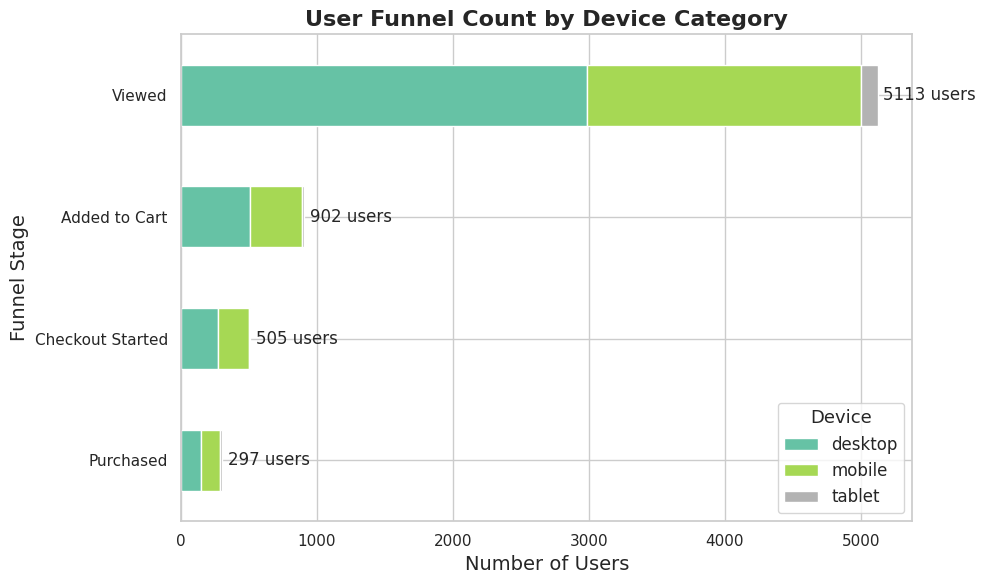

In [12]:
# Reuse the numeric funnel data
funnel_plot_data = funnel_numeric.copy()
funnel_plot_data.index = ['Viewed', 'Added to Cart', 'Checkout Started', 'Purchased']

fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal stacked bar plot
funnel_plot_data.plot(kind='barh', stacked=True, ax=ax, colormap='Set2')
ax.invert_yaxis()
# Add sum count per funnel
for i, count in enumerate(counts):
  plt.text(count + 50, i, f"{int(count)} users", va='center', fontsize=12)
# Titles and labels
ax.set_title('User Funnel Count by Device Category', fontsize=16, weight='bold')
ax.set_xlabel('Number of Users', fontsize=14)
ax.set_ylabel('Funnel Stage', fontsize=14)
ax.legend(title='Device', fontsize=12, title_fontsize=13)

# Tidy layout
plt.tight_layout()

# Save figure
plt.savefig('user_funnel_by_device.png', dpi=300)

plt.show()

**Interpretation**:
- **Overall drop-off is steep**: Only ~6% of users who view products end up purchasing (consistent with the previous analysis for Question 1).
- **Mobile and desktop dominate**: These two account for **over 95%** of all user traffic.
- Tablet traffic is minimal, but conversion rates are **not drastically different**, suggesting device type alone is not driving drop-off.

### Question 2.2 (Work in Progress): What factors influence the high drop-off from viewing to adding-to-cart?

Rationale: Understanding why users view products but don’t add them to cart is essential for **identifying friction points** in the e-commerce funnel. This step has the highest drop-off, and improving it can **directly increase conversions**. By analyzing user- and session-level features, we aim to uncover patterns that explain this behavior and **inform product, UX, or marketing optimizations**.

Data: We use GA4 public data (`events_*` tables), focusing on `view_item` and `add_to_cart` events. Key features include:
- `user_pseudo_id`: Unique (anonymous) user ID
- `event_name`: Event type (view, cart, etc.)
- `device.category`: Desktop / Mobile / Tablet
- `geo.continent`: Geographic info
- `traffic_source.source`, `traffic_source.medium`: Acquisition source
- `event_date`: Temporal pattern

A future step involves fitting a model to quantify how these factors affect the likelihood of adding to cart after viewing.
